# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import pickle
import re

from sqlalchemy import create_engine

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql("SELECT * FROM labeled_messages", engine)

X = df.filter(items=['id', 'message', 'original', 'genre'])
y = df.drop(['id', 'message', 'original', 'genre', 'child_alone'], axis=1)

#Mapping the '2' values in 'related' to '1' - because I consider them as a response (that is, '1')
y['related']=y['related'].map(lambda x: 1 if x == 2 else x)

df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
display(type(X))
display(type(y))

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc6a757cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbc69c90d30>]], dtype=object)

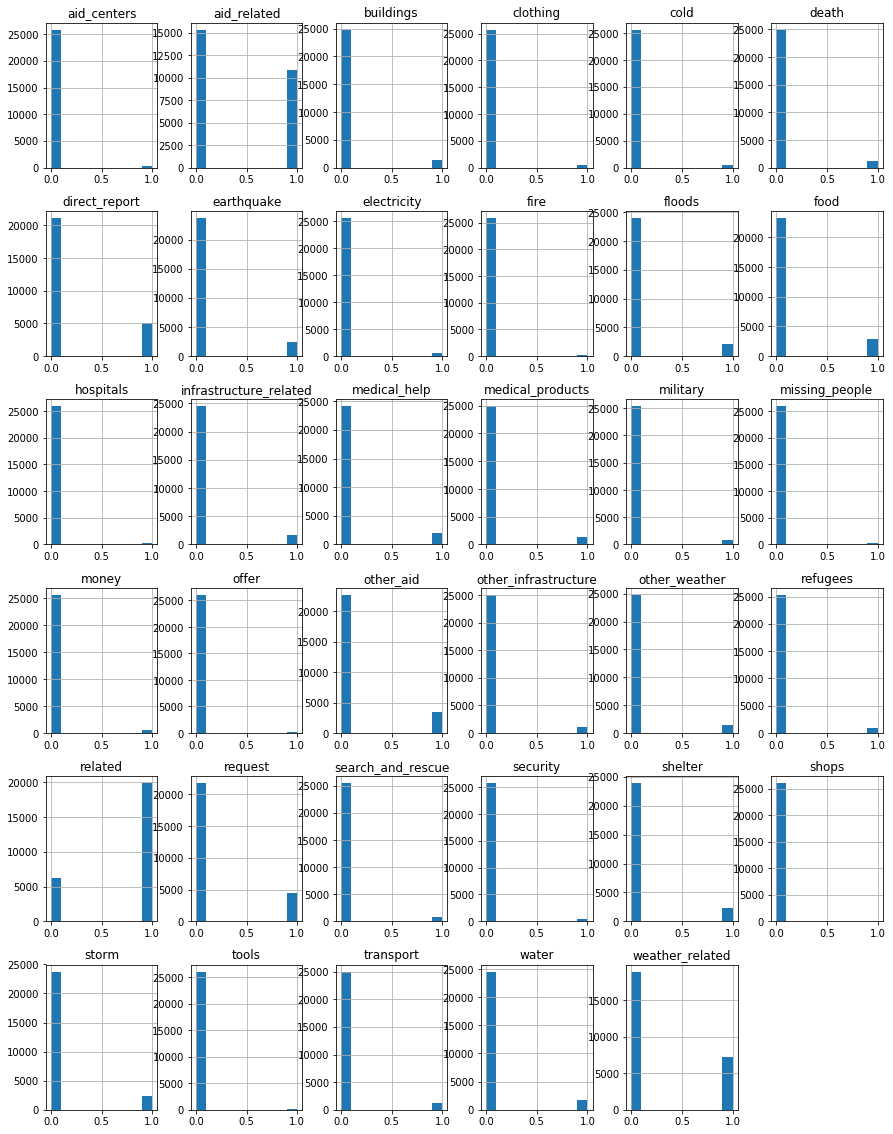

In [5]:
#just to see possible values distribution within classes
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
y.hist(ax = ax)

### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    parameters:
    text: string. String containing message
       
    Returns:
    stemmed: list of strings. List containing normalized and stemmed word tokens.
    """
    # Tokenizing words
    tokens = nltk.word_tokenize(text)
    # Stem word tokens and remove stop words
    lemmatizer = nltk.WordNetLemmatizer()
    
    stemmed = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    
    return stemmed

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.


pipeline = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultiOutputClassifier(RandomForestClassifier()))
                    ])

In [14]:
pipeline = Pipeline([('cvect', CountVectorizer(tokenizer = tokenize)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                     ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
display(np.unique(y_train))
display(np.unique(y_test))

array([0, 1])

array([0, 1])

In [10]:
#train pipeline
np.random.seed(15)
pipeline.fit(X_train['message'], y_train)

Pipeline(memory=None,
     steps=[('cvect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...oob_score=False, random_state=None,
            verbose=0, warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
#prediction with training set and test set
y_pred_test = pipeline.predict(X_test['message'])
y_pred_train = pipeline.predict(X_train['message'])

print(classification_report(y_test.values, y_pred_test, target_names=y.columns.values))
print()
print('\n',classification_report(y_train.values, y_pred_train, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.84      0.91      0.88      4941
               request       0.85      0.35      0.49      1152
                 offer       0.00      0.00      0.00        29
           aid_related       0.74      0.53      0.62      2744
          medical_help       0.71      0.04      0.08       559
      medical_products       0.77      0.07      0.13       334
     search_and_rescue       0.71      0.03      0.05       191
              security       0.00      0.00      0.00       111
              military       1.00      0.01      0.02       208
                 water       0.88      0.18      0.30       440
                  food       0.83      0.30      0.44       714
               shelter       0.79      0.16      0.26       605
              clothing       0.67      0.02      0.04        94
                 money       0.80      0.03      0.06       135
        missing_people       0.00      

### 6. Improve your model
Use grid search to find better parameters. 

In [15]:
parameters = {'clf__max_depth': [10, 20, None],
              'clf__min_samples_leaf': [1, 2, 4],
              'clf__min_samples_split': [2, 5, 8],
              'clf__n_estimators': [20, 50]}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1_micro', verbose = 18, n_jobs=-1)

In [16]:
improved_model = cv.fit(X_train['message'], y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20 
[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20, score=0.3932502368977331, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20, score=0.3893002657218777, total=  11.8s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=20, score=0.38275290215588725, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.6s remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.37881633705299605, total=  14.3s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.37628441516594474, total=  14.4s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.38036900369003696, total=  14.2s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20, score=0.39132181599035765, total=  11.7s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20, score=0.3749507397986601, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=20, score=0.38061518034963493, total=  11.8s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.3785038122951122, total=  14.1s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.37942122186495175, total=  14.3s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  3.9min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.37979544363622936, total=  14.4s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.3min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20, score=0.38699044061092186, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  4.6min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20, score=0.3795307645609399, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20 


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  4.9min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=20, score=0.38775285436322915, total=  11.9s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.3min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50, score=0.3786014295188269, total=  14.3s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  5.6min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50, score=0.3768696772346668, total=  14.4s
[CV] clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  6.0min remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=8, clf__n_estimators=50, score=0.382756079587325, total=  14.2s
[CV] clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20 
[CV]  clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20, score=0.3847761522384776, total=  11.8s
[CV] clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20 
[CV]  clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20, score=0.38199843092504104, total=  11.7s
[CV] clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20 
[CV]  clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=20, score=0.3877506058603217, total=  11.8s
[CV] clf__max_depth=10, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__max_depth=10, clf__min_samples_leaf=2, clf__min_s

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 67.4min finished


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [17]:
y_pred_test_1 = improved_model.predict(X_test['message'])
y_pred_train_1 = improved_model.predict(X_train['message'])

print(classification_report(y_test.values, y_pred_test_1, target_names=y.columns.values))
print()
print('\n',classification_report(y_train.values, y_pred_train_1, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.82      0.95      0.88      4941
               request       0.86      0.39      0.54      1152
                 offer       0.00      0.00      0.00        29
           aid_related       0.80      0.50      0.61      2744
          medical_help       0.78      0.01      0.02       559
      medical_products       0.78      0.02      0.04       334
     search_and_rescue       1.00      0.01      0.02       191
              security       0.00      0.00      0.00       111
              military       0.83      0.02      0.05       208
                 water       0.94      0.15      0.26       440
                  food       0.87      0.28      0.42       714
               shelter       0.93      0.13      0.23       605
              clothing       0.50      0.02      0.04        94
                 money       0.67      0.01      0.03       135
        missing_people       0.00      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
# Using Decision Tree Classifier now 
pipeline_new = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultiOutputClassifier(
                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
                    ))
                        ])

# Improved parameters 
parameters_new = {
                'clf__estimator__n_estimators': [100, 200],
                'clf__estimator__learning_rate': [0.1, 0.3]
                }


In [20]:
# new model with improved parameters
cv2 = GridSearchCV(pipeline_new, param_grid=parameters_new, cv=3, scoring='f1_micro', verbose=10)

In [ ]:
#further improved model
improved_model_2 = cv2.fit(X_train['message'], y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.47367464845027435, total= 4.0min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.48613365197695785, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.5min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.4740953578162881, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.7min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.5009170572651315, total= 7.6min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 20.8min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.5166241341596792, total= 7.6min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.8min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.503558489802674, total= 7.6min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 37.0min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.5101755418982078, total= 3.9min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 41.2min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.529757798031882, total= 3.9min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 45.4min remaining:    0.0s


In [ ]:
improved_model_2.best_params_

In [ ]:
# prediction with test set and training set
y_pred_test_2 = improved_model_2.predict(X_test['message'])
y_pred_train_2 = improved_model_2.predict(X_train['message'])

print(classification_report(y_test.values, y_pred_test_2, target_names=y.columns.values))
print()
print('\n',classification_report(y_train.values, y_pred_train_2, target_names=y.columns.values))

### 9. Export your model as a pickle file

In [ ]:
# Pickle best model
pickle.dump(improved_model_2, open('final_disaster_model.sav', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.